<a href="https://colab.research.google.com/github/armandoordonez/deeplearning/blob/main/6_Overfitting_and_underfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import keras
keras.__version__

'2.15.0'

# Overfitting and underfitting

Based on the code of the book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff).

In [27]:
numero_palabras = 10000 # define las palabras usadas del dataset

from keras.datasets import imdb
# https://keras.io/api/datasets/imdb/
import numpy as np

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=numero_palabras)

In [28]:
type(train_data)

numpy.ndarray

In [29]:
train_data.shape

(25000,)

In [30]:
def vectorize_sequences(sequences, dimension=numero_palabras):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

# Fighting overfitting

## Reducing the network's size


The simplest way to prevent overfitting is to reduce the size of the model, i.e. the number of learnable parameters in the model (which is
determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is
often referred to as the model's "capacity". Intuitively, a model with more parameters will have more "memorization capacity" and therefore
will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any
generalization power. For instance, a model with 500,000 binary parameters could easily be made to learn the class of every digits in the
MNIST training set: we would only need 10 binary parameters for each of the 50,000 digits. Such a model would be useless for classifying
new digit samples. Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge
is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn this mapping as easily, and thus, in
order to minimize its loss, it will have to resort to learning compressed representations that have predictive power regarding the targets
-- precisely the type of representations that we are interested in. At the same time, keep in mind that you should be using models that have
enough parameters that they won't be underfitting: your model shouldn't be starved for memorization resources. There is a compromise to be
found between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine what the right number of layers is, or what the right size for each layer is. You
will have to evaluate an array of different architectures (on your validation set, not on your test set, of course) in order to find the
right model size for your data. The general workflow to find an appropriate model size is to start with relatively few layers and
parameters, and start increasing the size of the layers or adding new layers until you see diminishing returns with regard to the
validation loss.

Let's try this on our movie review classification network. Our original network was as such:

In [31]:
from keras import models
from keras.layers import Dense
from keras import layers

original_model = models.Sequential()
original_model.add(Dense(16, activation='relu', input_shape=(numero_palabras,)))
original_model.add(Dense(16, activation='relu'))
original_model.add(Dense(1, activation='sigmoid'))

original_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

Now let's try to replace it with this smaller network:

In [32]:
smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(numero_palabras,)))
smaller_model.add(layers.Dense(4, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))

smaller_model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['acc'])


Here's a comparison of the validation losses of the original network and the smaller network. The dots are the validation loss values of
the smaller network, and the crosses are the initial network (remember: a lower validation loss signals a better model).

In [33]:
original_hist = original_model.fit(x_train, y_train,
                                   epochs=20,
                                   batch_size=512,
                                   validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 7s 128ms/step - loss: 0.4605 - acc: 0.8186 - val_loss: 0.3583 - val_acc: 0.8645
Epoch 2/20
49/49 [==============================] - 2s 39ms/step - loss: 0.2725 - acc: 0.9027 - val_loss: 0.2865 - val_acc: 0.8875
Epoch 3/20
49/49 [==============================] - 3s 59ms/step - loss: 0.2133 - acc: 0.9229 - val_loss: 0.2826 - val_acc: 0.8872
Epoch 4/20
49/49 [==============================] - 3s 52ms/step - loss: 0.1808 - acc: 0.9352 - val_loss: 0.3113 - val_acc: 0.8758
Epoch 5/20
49/49 [==============================] - 2s 39ms/step - loss: 0.1583 - acc: 0.9435 - val_loss: 0.3044 - val_acc: 0.8804
Epoch 6/20
49/49 [==============================] - 2s 38ms/step - loss: 0.1417 - acc: 0.9493 - val_loss: 0.3145 - val_acc: 0.8799
Epoch 7/20
49/49 [==============================] - 2s 38ms/step - loss: 0.1262 - acc: 0.9572 - val_loss: 0.3300 - val_acc: 0.8770
Epoch 8/20
49/49 [==============================] - 3s 52ms/step - loss: 0.1136 - 

In [ ]:
smaller_model_hist = smaller_model.fit(x_train, y_train,
                                       epochs=20,
                                       batch_size=512,
                                       validation_data=(x_test, y_test))

In [9]:
epochs = range(1, 21)
original_val_loss = original_hist.history['val_loss']
smaller_model_val_loss = smaller_model_hist.history['val_loss']

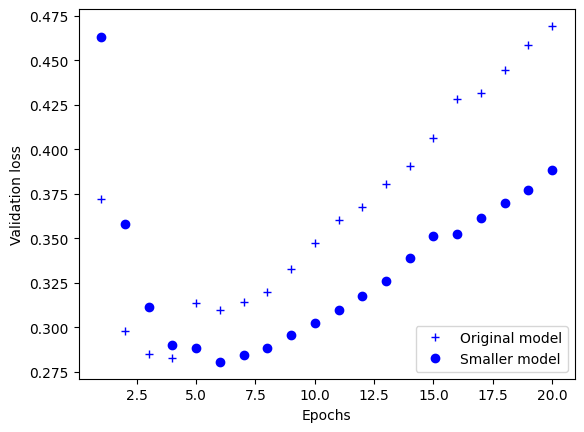

In [10]:
import matplotlib.pyplot as plt

# b+ is for "blue cross"
plt.plot(epochs, original_val_loss, 'b+', label='Original model')
# "bo" is for "blue dot"
plt.plot(epochs, smaller_model_val_loss, 'bo', label='Smaller model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()


As you can see, the smaller network starts overfitting later than the reference one (after 6 epochs rather than 4) and its performance
degrades much more slowly once it starts overfitting.

Now, for kicks, let's add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [11]:
bigger_model = models.Sequential()
bigger_model.add(layers.Dense(128, activation='relu', input_shape=(numero_palabras,)))
bigger_model.add(layers.Dense(128, activation='relu'))
bigger_model.add(layers.Dense(1, activation='sigmoid'))

bigger_model.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['acc'])

In [12]:
bigger_model_hist = bigger_model.fit(x_train, y_train,
                                     epochs=20,
                                     batch_size=512,
                                     validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 6s 110ms/step - loss: 0.4506 - acc: 0.7922 - val_loss: 0.3017 - val_acc: 0.8808
Epoch 2/20
49/49 [==============================] - 3s 66ms/step - loss: 0.2816 - acc: 0.8858 - val_loss: 0.2784 - val_acc: 0.8867
Epoch 3/20
49/49 [==============================] - 4s 77ms/step - loss: 0.2317 - acc: 0.9080 - val_loss: 0.2787 - val_acc: 0.8852
Epoch 4/20
49/49 [==============================] - 3s 64ms/step - loss: 0.2006 - acc: 0.9209 - val_loss: 0.2883 - val_acc: 0.8824
Epoch 5/20
49/49 [==============================] - 3s 64ms/step - loss: 0.1727 - acc: 0.9318 - val_loss: 0.2979 - val_acc: 0.8768
Epoch 6/20
49/49 [==============================] - 4s 93ms/step - loss: 0.1417 - acc: 0.9471 - val_loss: 0.3025 - val_acc: 0.8795
Epoch 7/20
49/49 [==============================] - 3s 64ms/step - loss: 0.1056 - acc: 0.9636 - val_loss: 0.3336 - val_acc: 0.8758
Epoch 8/20
49/49 [==============================] - 3s 71ms/step - loss: 0.0831 - 

Here's how the bigger network fares compared to the reference one. The dots are the validation loss values of the bigger network, and the
crosses are the initial network.

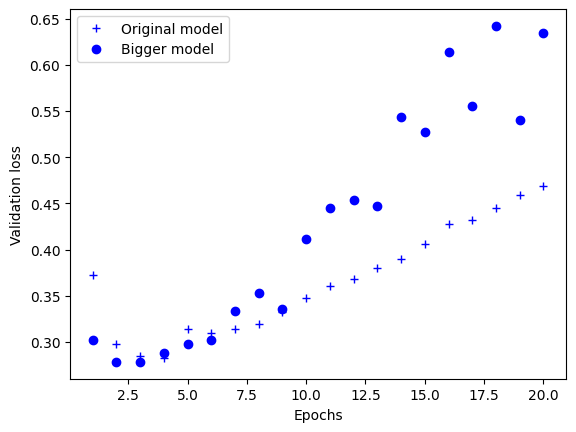

In [13]:
bigger_model_val_loss = bigger_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_val_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()


The bigger network starts overfitting almost right away, after just one epoch, and overfits much more severely. Its validation loss is also
more noisy.

Meanwhile, here are the training losses for our two networks:

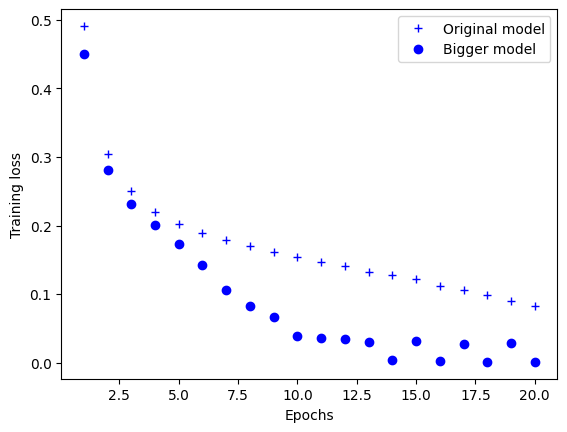

In [14]:
original_train_loss = original_hist.history['loss']
bigger_model_train_loss = bigger_model_hist.history['loss']

plt.plot(epochs, original_train_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_train_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()

plt.show()

As you can see, the bigger network gets its training loss near zero very quickly. The more capacity the network has, the quicker it will be
able to model the training data (resulting in a low training loss), but the more susceptible it is to overfitting (resulting in a large
difference between the training and validation loss).

## Adding weight regularization


You may be familiar with _Occam's Razor_ principle: given two explanations for something, the explanation most likely to be correct is the
"simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some
training data and a network architecture, there are multiple sets of weights values (multiple _models_) that could explain the data, and
simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer
parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity
of a network by forcing its weights to only take small values, which makes the distribution of weight values more "regular". This is called
"weight regularization", and it is done by adding to the loss function of the network a _cost_ associated with having large weights. This
cost comes in two flavors:

* L1 regularization, where the cost added is proportional to the _absolute value of the weights coefficients_ (i.e. to what is called the
"L1 norm" of the weights).
* L2 regularization, where the cost added is proportional to the _square of the value of the weights coefficients_ (i.e. to what is called
the "L2 norm" of the weights). L2 regularization is also called _weight decay_ in the context of neural networks. Don't let the different
name confuse you: weight decay is mathematically the exact same as L2 regularization.

In Keras, weight regularization is added by passing _weight regularizer instances_ to layers as keyword arguments. Let's add L2 weight
regularization to our movie review classification network:

In [15]:
from keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(numero_palabras,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

In [16]:
l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

`l2(0.001)` means that every coefficient in the weight matrix of the layer will add `0.001 * weight_coefficient_value` to the total loss of
the network. Note that because this penalty is _only added at training time_, the loss for this network will be much higher at training
than at test time.

Here's the impact of our L2 regularization penalty:

In [17]:
l2_model_hist = l2_model.fit(x_train, y_train,
                             epochs=20,
                             batch_size=512,
                             validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 4s 60ms/step - loss: 0.5163 - acc: 0.8066 - val_loss: 0.3998 - val_acc: 0.8715
Epoch 2/20
49/49 [==============================] - 1s 27ms/step - loss: 0.3423 - acc: 0.8913 - val_loss: 0.3436 - val_acc: 0.8823
Epoch 3/20
49/49 [==============================] - 1s 21ms/step - loss: 0.2917 - acc: 0.9076 - val_loss: 0.3314 - val_acc: 0.8832
Epoch 4/20
49/49 [==============================] - 1s 20ms/step - loss: 0.2703 - acc: 0.9145 - val_loss: 0.3461 - val_acc: 0.8753
Epoch 5/20
49/49 [==============================] - 1s 20ms/step - loss: 0.2580 - acc: 0.9196 - val_loss: 0.3309 - val_acc: 0.8826
Epoch 6/20
49/49 [==============================] - 1s 27ms/step - loss: 0.2504 - acc: 0.9209 - val_loss: 0.3463 - val_acc: 0.8767
Epoch 7/20
49/49 [==============================] - 1s 20ms/step - loss: 0.2467 - acc: 0.9230 - val_loss: 0.3414 - val_acc: 0.8805
Epoch 8/20
49/49 [==============================] - 1s 21ms/step - loss: 0.2410 - a

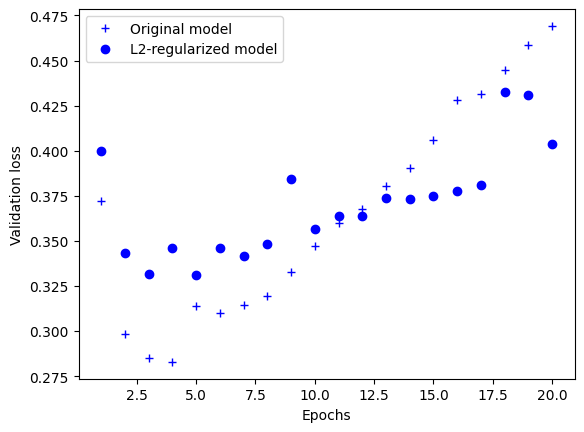

In [18]:
l2_model_val_loss = l2_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, l2_model_val_loss, 'bo', label='L2-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()



As you can see, the model with L2 regularization (dots) has become much more resistant to overfitting than the reference model (crosses),
even though both models have the same number of parameters.

As alternatives to L2 regularization, you could use one of the following Keras weight regularizers:

In [19]:
from keras import regularizers

# L1 regularization
regularizers.l1(0.001)

# L1 and L2 regularization at the same time
regularizers.l1_l2(l1=0.001, l2=0.001)

## Adding dropout


Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his
students at the University of Toronto. Dropout, applied to a layer, consists of randomly "dropping out" (i.e. setting to zero) a number of
output features of the layer during training. Let's say a given layer would normally have returned a vector `[0.2, 0.5, 1.3, 0.8, 1.1]` for a
given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. `[0, 0.5,
1.3, 0, 1.1]`. The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test
time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to
balance for the fact that more units are active than at training time.

Consider a Numpy matrix containing the output of a layer, `layer_output`, of shape `(batch_size, features)`. At training time, we would be
zero-ing out at random a fraction of the values in the matrix:

In [20]:
# At training time: we drop out 50% of the units in the output
layer_output *= np.randint(0, high=2, size=layer_output.shape)

NameError: name 'layer_output' is not defined


At test time, we would be scaling the output down by the dropout rate. Here we scale by 0.5 (because we were previous dropping half the
units):

In [ ]:
# At test time:
layer_output *= 0.5


Note that this process can be implemented by doing both operations at training time and leaving the output unchanged at test time, which is
often the way it is implemented in practice:

In [ ]:
# At training time:
layer_output *= np.randint(0, high=2, size=layer_output.shape)
# Note that we are scaling *up* rather scaling *down* in this case
layer_output /= 0.5


This technique may seem strange and arbitrary. Why would this help reduce overfitting? Geoff Hinton has said that he was inspired, among
other things, by a fraud prevention mechanism used by banks -- in his own words: _"I went to my bank. The tellers kept changing and I asked
one of them why. He said he didn’t know but they got moved around a lot. I figured it must be because it would require cooperation
between employees to successfully defraud the bank. This made me realize that randomly removing a different subset of neurons on each
example would prevent conspiracies and thus reduce overfitting"_.

The core idea is that introducing noise in the output values of a layer can break up happenstance patterns that are not significant (what
Hinton refers to as "conspiracies"), which the network would start memorizing if no noise was present.

In Keras you can introduce dropout in a network via the `Dropout` layer, which gets applied to the output of layer right before it, e.g.:

In [ ]:
model.add(layers.Dropout(0.5))

Let's add two `Dropout` layers in our IMDB network to see how well they do at reducing overfitting:

In [23]:
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(numero_palabras,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

In [25]:
dpt_model_hist = dpt_model.fit(x_train, y_train,
                               epochs=20,
                               batch_size=512,
                               validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 2s 48ms/step - loss: 0.1625 - acc: 0.9340 - val_loss: 0.4642 - val_acc: 0.8717
Epoch 2/20
49/49 [==============================] - 2s 35ms/step - loss: 0.1623 - acc: 0.9362 - val_loss: 0.4572 - val_acc: 0.8706
Epoch 3/20
49/49 [==============================] - 2s 49ms/step - loss: 0.1586 - acc: 0.9348 - val_loss: 0.4919 - val_acc: 0.8746
Epoch 4/20
49/49 [==============================] - 2s 39ms/step - loss: 0.1562 - acc: 0.9362 - val_loss: 0.5197 - val_acc: 0.8715
Epoch 5/20
49/49 [==============================] - 2s 33ms/step - loss: 0.1544 - acc: 0.9401 - val_loss: 0.5189 - val_acc: 0.8704
Epoch 6/20
49/49 [==============================] - 1s 21ms/step - loss: 0.1524 - acc: 0.9394 - val_loss: 0.5331 - val_acc: 0.8711
Epoch 7/20
49/49 [==============================] - 1s 21ms/step - loss: 0.1538 - acc: 0.9396 - val_loss: 0.5390 - val_acc: 0.8698
Epoch 8/20
49/49 [==============================] - 1s 21ms/step - loss: 0.1487 - a

Let's plot the results:

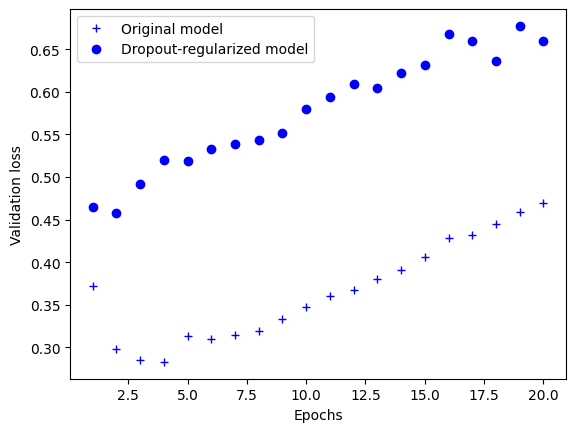

In [26]:
dpt_model_val_loss = dpt_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, dpt_model_val_loss, 'bo', label='Dropout-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()


Again, a clear improvement over the reference network.

To recap: here the most common ways to prevent overfitting in neural networks:

* Getting more training data.
* Reducing the capacity of the network.
* Adding weight regularization.
* Adding dropout.